In [82]:
from lcm.utils.checkpoint import load_from_json_checkpoint
import seaborn as sns
import pandas as pd
import torch

from lcm.trainers import CompartmentalTrainer
from lcm.utils.visualization import parse_date

import matplotlib.pyplot as plt
import datetime

In [49]:
# load model and dataset
exp_path = "./italy_dec31/"
checkpoint_path = os.path.join(exp_path, "checkpoint.json")
model, dataset = load_from_json_checkpoint(checkpoint_path)

dataset_size = dataset.train_size + dataset.val_size + dataset.test_size

In [86]:
figs_path = os.path.join(exp_path, "figs")
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

def savefig(figure, figures_path, figure_name):
    fig_path = os.path.join(figures_path, f"{figure_name}.pdf")
    figure.savefig(fig_path, bbox_inches='tight', transparent=False)

In [3]:
# create trainer

exp = CompartmentalTrainer(
    dataset=dataset,
    model=model,
    uuid_prefix="all_regions", uuid="",
)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


In [6]:
test_out = exp.test(model, dataset.test_dataloader(), verbose=False)[0]

Testing: 100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


In [304]:
# define utility funcs
def extend_param(value, length, fill_value=None):
    len_diff = length - value.shape[0]
    if fill_value is None:
        fill_value = value[-1]
    if len_diff > 0:
        return torch.cat((value, fill_value.expand(len_diff, 1)))
    else:
        return value

def get_column(values, mask):

    return torch.where(mask, values, torch.tensor(float('nan')))
    #column = [None] * col_slice.start + values + [None] * (dataset_size - col_slice.stop)
    #return column

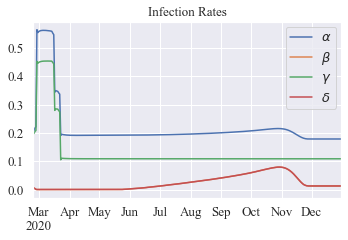

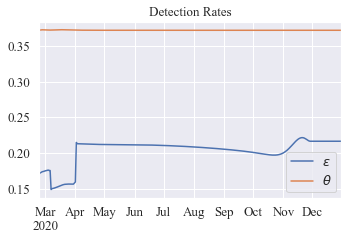

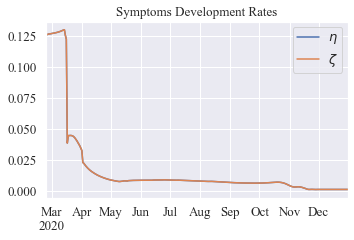

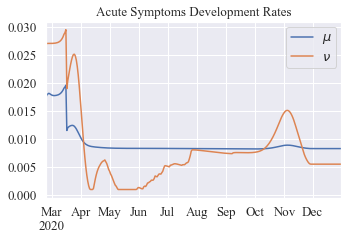

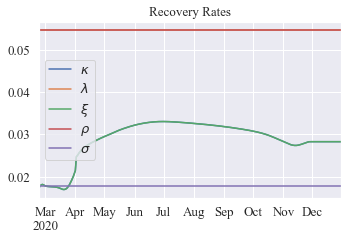

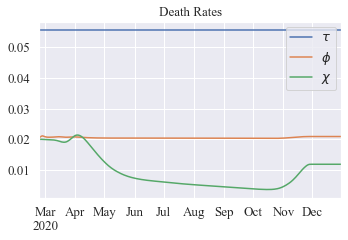

In [255]:
group_dfs = {}
params = model.params
start_date = parse_date(dataset.first_date[0]) # parse_date(dates[0])
dates_x = [(start_date + datetime.timedelta(int(n))).strftime("%Y-%m-%d") for n in range(0, dataset_size)]
#del matplotlib.font_manager.weight_dict['roman']
sns.set(font="Times New Roman")

font_size = '13'

for group_name, group in model.param_groups.items():
    group_df = pd.DataFrame()
    group_df['date'] = pd.to_datetime(dates_x)
    group_df.set_index('date', inplace=True)
    #group_df['test'] = [i for i in range(0, len(dates_x))]
    for param_name in group:
        group_df[f"$\{param_name}$"] = extend_param(params[param_name], dataset_size).detach().numpy()

    plot_title = group_name.replace("_", " ").title()
    plot = group_df.plot(title=plot_title, figsize=(5,3.5), fontsize=font_size)
    plot.title.set_fontsize(font_size)
    plt.setp(plot.get_legend().get_texts(), fontsize=font_size)
    plot.axes.xaxis.label.set_visible(False)
    
    figure = plot.get_figure()
    figure.set_tight_layout(True)
    savefig(figure, figs_path, group_name)


In [260]:
def get_data_from_loader(loader):
    x, targets, mask = list(loader)[0]
    targets = {
        key: value[0,:]
        for key, value in targets.items()
    }
    return x, targets,  extend_param(mask[0, :], dataset_size, torch.tensor(False)) # extend_param(mask[0, :], dataset_size)

In [333]:
mask = get_data_from_loader(dataset.train_dataloader())[2]

#get_column(test_out["hats"]["d"], mask)
curve_df[f"Prediction ({section})"] = get_column(test_out["hats"]["d"], mask).flatten().tolist()
#curve_df[f"Target ({section})"] = get_column(c_targets[section][key], mask).flatten().tolist()
curve_df

c_targets[section].shape
#curve_df[f"Target ({section})"] = get_column(c_targets[section], mask).flatten().tolist()

torch.Size([312, 1])

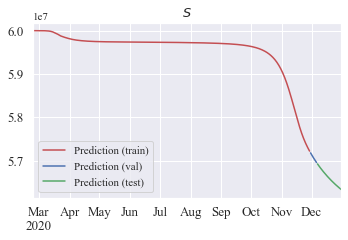

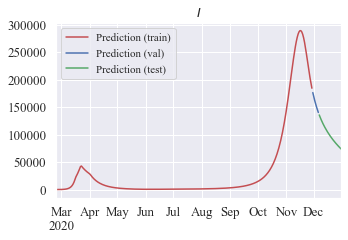

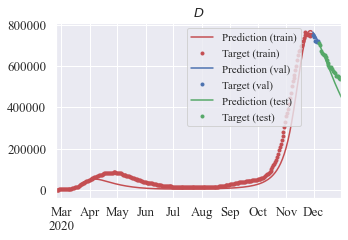

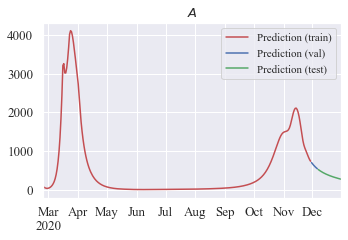

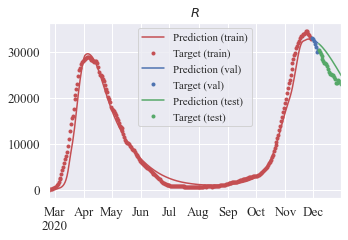

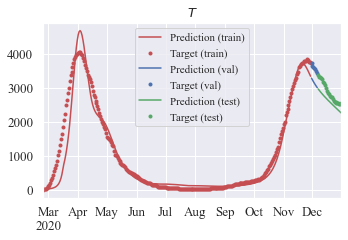

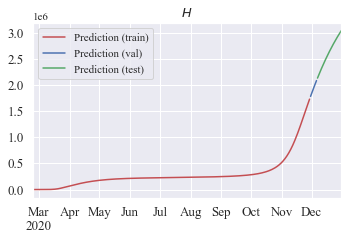

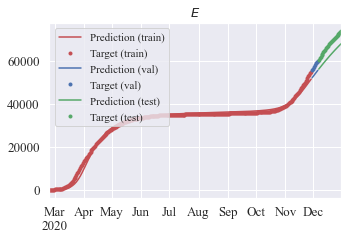

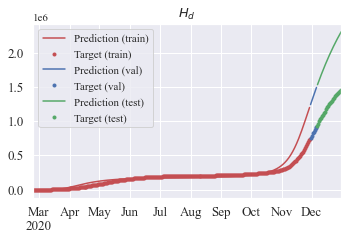

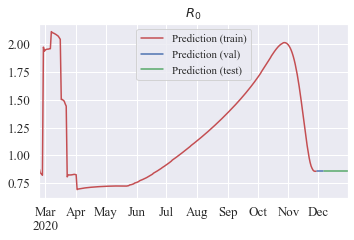

In [336]:
#for key in ["s", "i", "d", "a", "r", "t", "h", "e", "h_detected", "r0"]:

_, _, train_mask = get_data_from_loader(dataset.train_dataloader())
_, _, val_mask = get_data_from_loader(dataset.val_dataloader())
x, targets, test_mask = get_data_from_loader(dataset.test_dataloader())

hats = test_out["hats"]
for key in ["s", "i", "d", "a", "r", "t", "h", "e", "h_detected", "r0"]:
#for key in ["d"]:

    if key == "h_detected":
        plot_title = "$H_d$"
    elif key == "r0":
        plot_title = "$R_0$"
    else:
        plot_title = f"${key.upper()}$"

    curve_df = pd.DataFrame()
    curve_df['date'] = pd.to_datetime(dates_x[:])
    curve_df.set_index('date', inplace=True)
        
    if key in targets:
        c_targets = {
            "train": targets[key],
            "val": targets[key],
            "test": targets[key]
        }
    else:
        c_targets = {
            "train": None,
            "val": None,
            "test": None
        }

    masks = {
        "train": train_mask,
        "val": val_mask,
        "test": test_mask
    }

    for section, mask in masks.items():
        curve_df[f"Prediction ({section})"] = get_column(hats[key], mask).flatten().tolist()
        if c_targets[section] is not None: 
            curve_df[f"Target ({section})"] = get_column(c_targets[section], mask).flatten().tolist()
            curve_styles = ['-', '.'] * 3
            curve_colors = ['r'] * 2 + ['b'] * 2 + ['g'] * 2
        else:
            curve_styles = ['-'] * 3
            curve_colors = ['r', 'b', 'g']

    plot = curve_df.plot(title=plot_title, style=curve_styles, color=curve_colors, figsize=(5,3.5), grid=True, fontsize=font_size)
    plot.title.set_fontsize(font_size)
    plt.setp(plot.get_legend().get_texts(), fontsize=font_size)

    if key != 'd':
        plt.legend(loc='best')
    else:
        plt.legend(loc='upper center', bbox_to_anchor=(0.66,1.))
    #plt.setp(plot.texts, fontsize='1')
    plot.axes.xaxis.label.set_visible(False)
    
    figure = plot.get_figure()
    figure.set_tight_layout(True)

    savefig(figure, figs_path, key)